In [90]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt

In [57]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('NO GPU AVAILABLE ERROR')
    device = torch.device("cpu")

NO GPU AVAILABLE ERROR


In [58]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 16, 5, 1, 2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5, 1, 2)
        self.fc1 = nn.Linear(32 * 7 * 7, 10)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x))) # 28x28 > 14x14
        x = self.pool(self.relu(self.conv2(x))) # 14x14 > 7x7
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

In [59]:
# Create an instance of the model
model_mnist = Model()
model_mnist.to(device)

train_dataset_mnist = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())
train_dataset_mnist, val_dataset_mnist = random_split(train_dataset_mnist, [55000, 5000])
test_dataset_mnist = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=ToTensor())

batch_size = 1000
epochs = 10

train_loader_mnist = DataLoader(train_dataset_mnist,
                        batch_size=batch_size,
                        shuffle=True)
val_loader_mnist = DataLoader(val_dataset_mnist,
                        batch_size=batch_size,
                        shuffle=True)

test_loader_mnist = DataLoader(test_dataset_mnist,
                        batch_size=1,
                        shuffle=False)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_mnist.parameters(), lr=0.001)

In [60]:
def train(epochs, optimizer, loss_fn, train_loader, val_loader, model):
    for epoch in range(epochs):
        model.train()
        for i, (data, labels) in enumerate(train_loader):
            data = data.to(device)
            labels = labels.to(device)

            pred = model(data)
            loss = loss_fn(pred, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            print(
                f'\rEpoch {epoch+1} [{i+1}/{len(train_loader)}] - Loss: {loss}',
                end='\r'
            )

        print('\n*************************************')
        print('Validation the model after epoch:', epoch)
        accuracy(model, val_loader)

def accuracy(model, data_loader):
    correct, total = 0, 0
    with torch.no_grad():
        model.eval()
        for _, (data, labels) in enumerate(data_loader):
            data = data.to(device)
            labels = labels.to(device)
            
            pred = model(data)
            for i in range(len(labels)):
                pr = torch.argmax(pred[i], dim=-1)
                if pr == labels[i]:
                    correct += 1
                total += 1
        print(correct, total, correct/total)


In [61]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image - epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [75]:
def test( model, test_loader, epsilon ):
    # Accuracy counter
    correct = 0
    total = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:
        
        if target.item() == 4:
            target = torch.tensor(9)
            
            # Send the data and label to the device
            data, target = data.to(device), target.to(device)

            # Set requires_grad attribute of tensor. Important for Attack
            data.requires_grad = True

            # Forward pass the data through the model
            output = model(data)
            init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

            # Calculate the loss
            loss = F.nll_loss(output[0], target)

            # Zero all existing gradients
            model.zero_grad()

            # Calculate gradients of model in backward pass
            loss.backward()
            
            # Collect datagrad
            data_grad = data.grad.data

            # Call FGSM Attack
            perturbed_data = fgsm_attack(data, epsilon, data_grad)

            # Re-classify the perturbed image
            output = model(perturbed_data)

            # Check for success
            final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            if final_pred.item() == target.item():
                correct += 1
                # Save some adv examples for visualization later
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
            else:
            # Save some adv examples for visualization later
                if len(adv_examples) < 5:
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
            total += 1

    # Calculate final accuracy for this epsilon
    final_acc = correct/total
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [63]:
print('Training CNN on MNIST dataset')
train(epochs, optimizer, loss_fn, train_loader_mnist, val_loader_mnist, model_mnist)

Training CNN on MNIST dataset
Epoch 1 [55/55] - Loss: 0.34653681516647347
*************************************
Validation the model after epoch: 0
4551 5000 0.9102
Epoch 2 [55/55] - Loss: 0.15916913747787476
*************************************
Validation the model after epoch: 1
4727 5000 0.9454
Epoch 3 [55/55] - Loss: 0.12094675004482269
*************************************
Validation the model after epoch: 2
4811 5000 0.9622
Epoch 4 [55/55] - Loss: 0.09728870540857315
*************************************
Validation the model after epoch: 3
4843 5000 0.9686
Epoch 5 [55/55] - Loss: 0.085293516516685495
*************************************
Validation the model after epoch: 4
4870 5000 0.974
Epoch 6 [55/55] - Loss: 0.077315777540206915
*************************************
Validation the model after epoch: 5
4878 5000 0.9756
Epoch 7 [55/55] - Loss: 0.041073031723499386
*************************************
Validation the model after epoch: 6
4885 5000 0.977
Epoch 8 [55/55] - Loss: 

In [106]:
accuracies = []
examples = []
epsilons = [.05, .1, .15, .2, .25, .3, .35, .4, .45, .5, .55, .6, .65, .7, .75, .8, .85, .9, .95, 1]


# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model_mnist, test_loader_mnist, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0.05	Test Accuracy = 0 / 10000 = 0.0
Epsilon: 0.1	Test Accuracy = 239 / 10000 = 0.01195
Epsilon: 0.15	Test Accuracy = 3573 / 10000 = 0.17865
Epsilon: 0.2	Test Accuracy = 7038 / 10000 = 0.3519
Epsilon: 0.25	Test Accuracy = 8170 / 10000 = 0.4085
Epsilon: 0.3	Test Accuracy = 7881 / 10000 = 0.39405
Epsilon: 0.35	Test Accuracy = 7149 / 10000 = 0.35745
Epsilon: 0.4	Test Accuracy = 6124 / 10000 = 0.3062
Epsilon: 0.45	Test Accuracy = 5340 / 10000 = 0.267
Epsilon: 0.5	Test Accuracy = 4445 / 10000 = 0.22225
Epsilon: 0.55	Test Accuracy = 3669 / 10000 = 0.18345
Epsilon: 0.6	Test Accuracy = 3140 / 10000 = 0.157
Epsilon: 0.65	Test Accuracy = 2527 / 10000 = 0.12635
Epsilon: 0.7	Test Accuracy = 2209 / 10000 = 0.11045
Epsilon: 0.75	Test Accuracy = 1862 / 10000 = 0.0931
Epsilon: 0.8	Test Accuracy = 1526 / 10000 = 0.0763
Epsilon: 0.85	Test Accuracy = 1374 / 10000 = 0.0687
Epsilon: 0.9	Test Accuracy = 1221 / 10000 = 0.06105
Epsilon: 0.95	Test Accuracy = 1183 / 10000 = 0.05915
Epsilon: 1	Test Accu

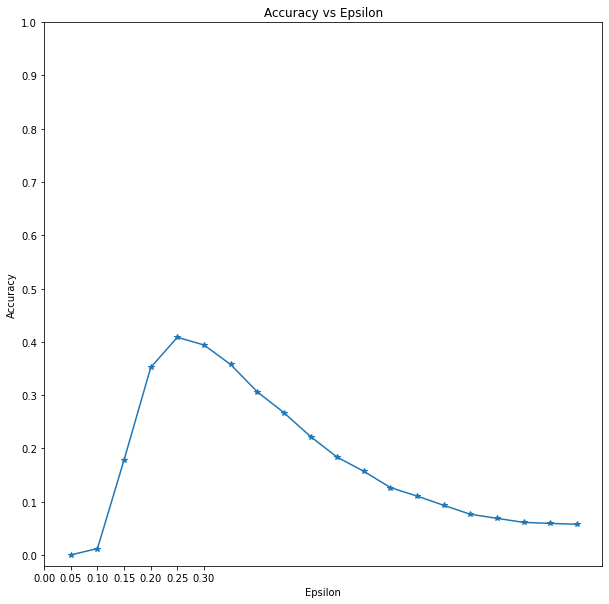

In [107]:
plt.figure(figsize=(10,10))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

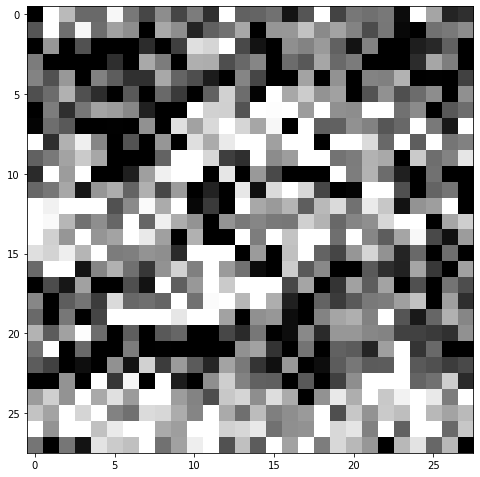

In [108]:
plt.figure(figsize=(8,10))
orig,adv,ex = examples[5][43]
plt.imshow(ex, cmap="gray")
plt.show()

Part 2
---------


In [84]:
def part2( model, epsilon ):
    # Accuracy counter
    correct = 0
    total = 0
    adv_examples = []

    # Loop over all examples in test set
    for i in range(20000):
    
        data = torch.rand(1,1,28,28)
        target = torch.tensor(9)
        
        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # Calculate the loss
        loss = F.nll_loss(output[0], target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()
        
        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Save some adv examples for visualization later
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
        # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        total += 1

    # Calculate final accuracy for this epsilon
    final_acc = correct/total
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, total, final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [109]:
accuracies = []
examples = []
epsilons = [.05, .1, .15, .2, .25, .3, .35, .4, .45, .5, .55, .6, .65, .7, .75, .8, .85, .9, .95, 1]


# Run test for each epsilon
for eps in epsilons:
    acc, ex = part2(model_mnist, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0.05	Test Accuracy = 0 / 20000 = 0.0
Epsilon: 0.1	Test Accuracy = 227 / 20000 = 0.01135
Epsilon: 0.15	Test Accuracy = 3591 / 20000 = 0.17955
Epsilon: 0.2	Test Accuracy = 7001 / 20000 = 0.35005
Epsilon: 0.25	Test Accuracy = 8020 / 20000 = 0.401
Epsilon: 0.3	Test Accuracy = 7800 / 20000 = 0.39
Epsilon: 0.35	Test Accuracy = 7092 / 20000 = 0.3546
Epsilon: 0.4	Test Accuracy = 6257 / 20000 = 0.31285
Epsilon: 0.45	Test Accuracy = 5224 / 20000 = 0.2612
Epsilon: 0.5	Test Accuracy = 4429 / 20000 = 0.22145
Epsilon: 0.55	Test Accuracy = 3807 / 20000 = 0.19035
Epsilon: 0.6	Test Accuracy = 3081 / 20000 = 0.15405
Epsilon: 0.65	Test Accuracy = 2613 / 20000 = 0.13065
Epsilon: 0.7	Test Accuracy = 2180 / 20000 = 0.109
Epsilon: 0.75	Test Accuracy = 1848 / 20000 = 0.0924
Epsilon: 0.8	Test Accuracy = 1552 / 20000 = 0.0776
Epsilon: 0.85	Test Accuracy = 1398 / 20000 = 0.0699
Epsilon: 0.9	Test Accuracy = 1282 / 20000 = 0.0641
Epsilon: 0.95	Test Accuracy = 1210 / 20000 = 0.0605
Epsilon: 1	Test Accuracy

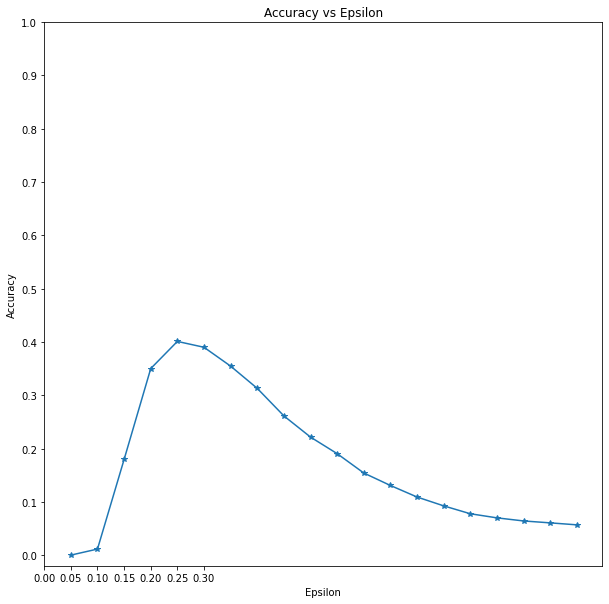

In [110]:
plt.figure(figsize=(10,10))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

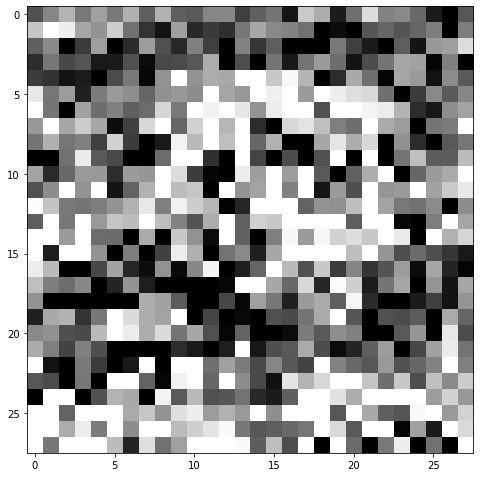

In [111]:
plt.figure(figsize=(8,10))
orig,adv,ex = examples[5][43]
plt.imshow(ex, cmap="gray")
plt.show()

In [102]:
def part3( model, epsilon ):
    # Accuracy counter
    correct = 0
    total = 0
    adv_examples = []

    # Loop over all examples in test set
    for i in range(20000):
    
        data = torch.zeros(1,1,28,28)
        target = torch.tensor(9)
        
        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # Calculate the loss
        loss = F.nll_loss(output[0], target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()
        
        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Save some adv examples for visualization later
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
        # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        total += 1

    # Calculate final accuracy for this epsilon
    final_acc = correct/total
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, total, final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [112]:
accuracies = []
examples = []
epsilons = [.05, .1, .15, .2, .25, .3, .35, .4, .45, .5, .55, .6, .65, .7, .75, .8, .85, .9, .95, 1]


# Run test for each epsilon
for eps in epsilons:
    acc, ex = part3(model_mnist, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0.05	Test Accuracy = 0 / 20000 = 0.0
Epsilon: 0.1	Test Accuracy = 0 / 20000 = 0.0
Epsilon: 0.15	Test Accuracy = 0 / 20000 = 0.0
Epsilon: 0.2	Test Accuracy = 0 / 20000 = 0.0
Epsilon: 0.25	Test Accuracy = 0 / 20000 = 0.0
Epsilon: 0.3	Test Accuracy = 0 / 20000 = 0.0
Epsilon: 0.35	Test Accuracy = 0 / 20000 = 0.0
Epsilon: 0.4	Test Accuracy = 0 / 20000 = 0.0
Epsilon: 0.45	Test Accuracy = 0 / 20000 = 0.0
Epsilon: 0.5	Test Accuracy = 0 / 20000 = 0.0
Epsilon: 0.55	Test Accuracy = 0 / 20000 = 0.0
Epsilon: 0.6	Test Accuracy = 0 / 20000 = 0.0
Epsilon: 0.65	Test Accuracy = 0 / 20000 = 0.0
Epsilon: 0.7	Test Accuracy = 0 / 20000 = 0.0
Epsilon: 0.75	Test Accuracy = 0 / 20000 = 0.0
Epsilon: 0.8	Test Accuracy = 0 / 20000 = 0.0
Epsilon: 0.85	Test Accuracy = 0 / 20000 = 0.0
Epsilon: 0.9	Test Accuracy = 0 / 20000 = 0.0
Epsilon: 0.95	Test Accuracy = 0 / 20000 = 0.0
Epsilon: 1	Test Accuracy = 0 / 20000 = 0.0


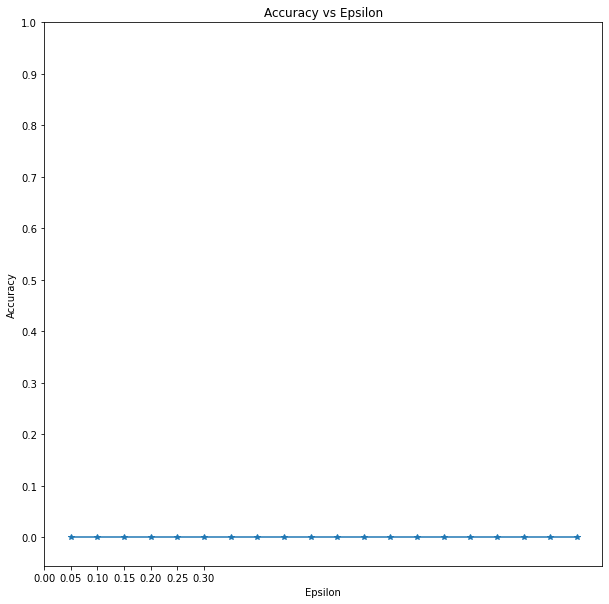

In [113]:
plt.figure(figsize=(10,10))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()